In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
sys.path.append('../..')
import torch
from torch.utils.data import DataLoader
from src.transforms import LabelMapper
from src.utils import load_model_from_folder, load_history_from_folder
from src.models import AttentionModel
import torchmetrics

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device.type)

cuda


In [3]:
torch.manual_seed(0)
torch.use_deterministic_algorithms(False)

In [4]:
HISTORIES_DIR = "/home/bracs/Desktop/Attention Models/ResNet18/ATT1/histories"
WEIGHTS_DIR = "/home/bracs/Desktop/Attention Models/ResNet18/ATT1/weights"

In [5]:
NUM_CLASSES = 3
dropout = 0.2
filters_in = 512
filters_out = 64

# Loading the Model

In [6]:
model = AttentionModel(
    num_classes=NUM_CLASSES,
    dropout=dropout,
    filters_in=filters_in,
    filters_out=filters_out
).to(device)

In [7]:
load_model_from_folder(model=model, weights_folder=WEIGHTS_DIR, verbose=True,weights_id='best_weights/1713082852.082908_epoch=6.pt')

loading weights with name : /home/bracs/Desktop/Attention Models/ResNet18/ATT1/weights/best_weights/1713082852.082908_epoch=6.pt


# Learning Graph

In [8]:
history_df = load_history_from_folder(HISTORIES_DIR)

train_his = history_df[history_df["split"] == "train"]
val_his = history_df[history_df["split"] == "val"]

In [9]:
def plot_loss_accuracy(train_history, val_history, title):
    fig, ax = plt.subplots(ncols=2)
    fig.suptitle(title, fontsize=16)
    fig.set_size_inches(20, 6)

    ax[0].plot(train_history['epoch'], train_history['loss'], label='Training Loss', color='blue')
    ax[0].plot(val_history['epoch'], val_his['loss'], label='Validation Loss', color='orange')
    ax[0].set_title('Training Loss')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss')
    ax[0].legend()
    ax[0].grid()

    ax[1].plot(train_history['epoch'], train_history['accuracy'], label='Training Accuracy', color='blue')
    ax[1].plot(val_history['epoch'], val_his['accuracy'], label='Validation Accuracy', color='orange')
    ax[1].set_title('Training Accuracy')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Accuracy')
    ax[1].legend()
    ax[1].grid()

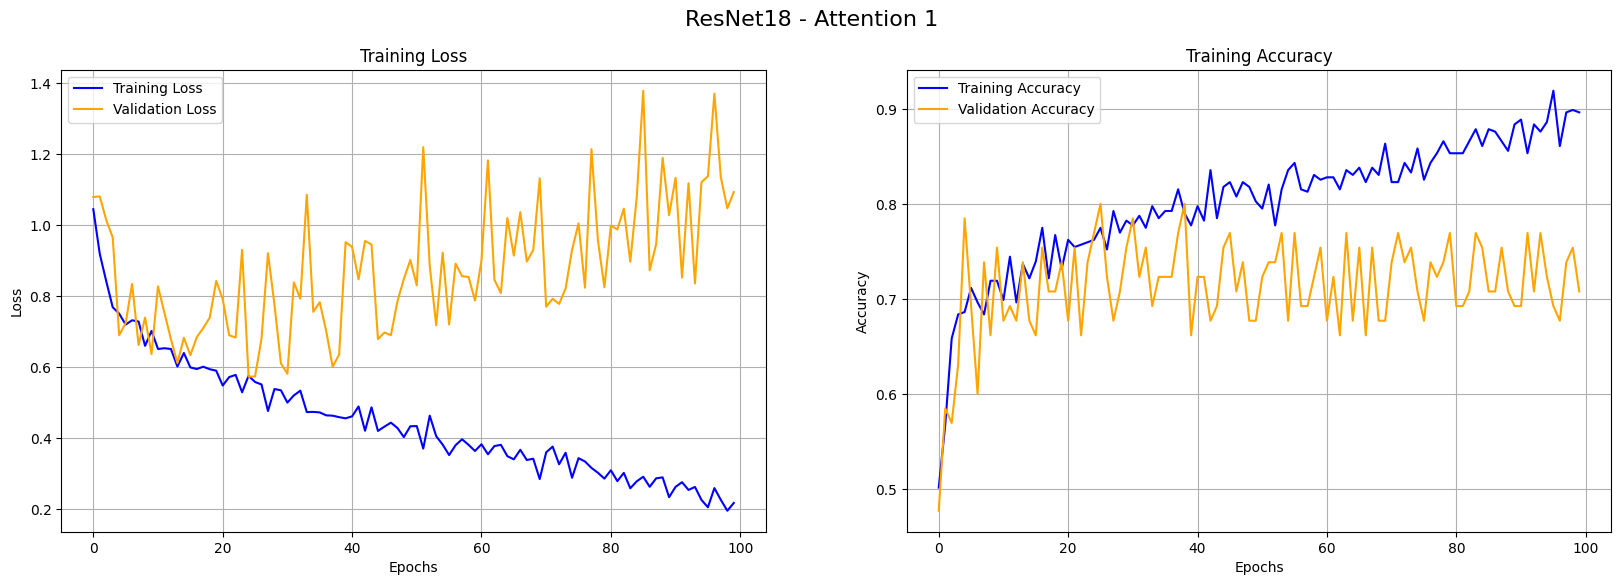

In [10]:
plot_loss_accuracy(train_history=train_his, val_history=val_his, title="ResNet18 - Attention 1")

In [11]:
from src.transforms import Pipeline,Transpose,Flip,LeftShift,RightShift,UpShift,DownShift
from torchvision.transforms import Lambda,RandomChoice
from src.datasets import TensorDataset

def create_loaders(
    test_dir : str,
    num_workers : int,
    prefetch_factor : int
) -> tuple[DataLoader, DataLoader]:
        
    test_transform = Lambda(lambd=lambda x : torch.unsqueeze(x, dim=0))
    
    test_data = TensorDataset(root=test_dir,transform=test_transform)

    test_loader = DataLoader(dataset=test_data, batch_size=1, shuffle=True,num_workers=num_workers,prefetch_factor=prefetch_factor)

    return test_loader

Key OPENSLIDE_PATH not found in /home/bracs/Breast-Cancer-Detection/.env.


In [12]:
test_dir = "/media/bracs/08AB3E166632A43D/ResNet18 tensors (copy)/test"
test_dataloader = create_loaders(test_dir, num_workers=4, prefetch_factor=2)

In [13]:
loss = torch.nn.CrossEntropyLoss()
accuracy = torchmetrics.Accuracy(num_classes=NUM_CLASSES, task='multiclass').to(device)
f1_score = torchmetrics.F1Score(num_classes=NUM_CLASSES,task='multiclass',average='macro').to(device)
metrics = {'accuracy': accuracy, 'f1_score': f1_score}

In [14]:
def compute_metrics(
        y:torch.Tensor,
        y_hat:torch.Tensor
    ) -> dict[str, torch.Tensor]:
        """
            compute the different metrics.

            - y : torch.Tensor.
            - y_hat : torch.Tensor.

            Retuns : 
            - None.
        """

        result = {}

        for name,metric in metrics.items():
            result[name] = metric(y_hat, y).item()

        return result

In [15]:
def test_on_batch(model, X_batch:torch.Tensor) -> tuple[float,torch.Tensor]:
        """
            applies one validation step on a batch.

            - X_batch : torch.Tensor.

            Returns :
            - torch.Tensor : the predictions.
        """

        # 1- Forward pass
        y_hat = model(X_batch)

        return y_hat

In [16]:
def add_dicts(dict1 : dict, dict2 : dict) -> dict[str,torch.Tensor]:
    """
        adds the values of tow dictionaries together.
        Returns : 
        - a new dictionary containing the results.
    """

    result = {}

    for key,value in dict1.items():
        result[key] = value + dict2[key]

    return result


In [17]:
def div_dict(dict_ : dict, by : int):
    """
        divides the values of dictionary by a given value.
        Returns : 
        - a new dictionary containing the results.
    """

    result = {}

    for key,value in dict_.items():
        result[key] = dict_[key] / by

    return result

In [18]:
def get_results_dict() -> dict[str,float] :
    """
        Returns :
        - a new dictionary containing the keys of the metrics with a default value of zero.
    """
    
    results = {}
 
    for name in list(metrics.keys()):
        results[name] = 0.0
 
    return results

In [19]:
print(" - Testing the model on the test set. ")

test_results = get_results_dict()

Y_hat = []

if test_dataloader is not None:

    # put the model in test mode
    model.eval()
    
    with torch.inference_mode():
        for X_batch,y_batch in test_dataloader:
            # put the data in the rightd device
            X_batch,y_batch = X_batch.to(device),y_batch.to(device)
            y_hat = test_on_batch(model, X_batch)
            Y_hat.append(y_hat)
    
    test_results = div_dict(test_results, len(test_dataloader))

Y_hat = torch.stack(Y_hat)

print(" - Done.")

 - Testing the model on the test set. 


 - Done.


In [ ]:
print(Y_hat.shape)

In [20]:
test_results

{'accuracy': 0.5862068965517241, 'f1_score': 0.5862068965517241}